In [1]:
!pip install transformers datasets accelerate peft torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, recall_score
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from peft import PeftModel, PeftConfig
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# مسیر مدل فاین‌تیون‌شده (فرض بر اینه که در MyDrive ذخیره شده)
model_path = "/content/drive/MyDrive/xlm_roberta_finetuned_9L"

# فایل‌های پرتورب‌شده‌ی کاراکتری
perturbation_files = {
    "10%": "/content/x_fact_test_charlevel_perturbed_10.csv",
    "30%": "/content/x_fact_test_charlevel_perturbed_30.csv",
    "60%": "/content/x_fact_test_charlevel_perturbed_60.csv"
}

# فایل آموزش برای ساخت LabelEncoder
train_file = "/content/x_fact_train_oversampled_9L.csv"


In [4]:
# لود مدل پایه + LoRA
peft_config = PeftConfig.from_pretrained(model_path)
base_model = AutoModelForSequenceClassification.from_pretrained(
    peft_config.base_model_name_or_path,
    num_labels=4  # تعداد کلاس‌ها
)
tokenizer = AutoTokenizer.from_pretrained(peft_config.base_model_name_or_path)
model = PeftModel.from_pretrained(base_model, model_path)

# تعریف متریک‌ها
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average="weighted"),
        "recall": recall_score(labels, predictions, average="weighted")
    }

# تعریف Trainer برای ارزیابی
training_args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size=8,
    logging_dir="./logs"
)
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [5]:
train_df = pd.read_csv(train_file)
label_encoder = LabelEncoder()
label_encoder.fit(train_df["label"])


LabelEncoder()

In [6]:
from collections import defaultdict

language_results = []

def tokenize_function(texts):
    return tokenizer(texts, truncation=True, padding="max_length", max_length=512)

for perturb_name, path in perturbation_files.items():
    df = pd.read_csv(path)
    df["label"] = label_encoder.transform(df["label"])
    languages = df["source_language"].unique()

    print(f"\n Evaluating for perturbation: {perturb_name}")
    for lang in languages:
        df_lang = df[df["source_language"] == lang]
        encodings = tokenize_function(df_lang["claim"].tolist())

        dataset = Dataset.from_dict({
            "input_ids": encodings["input_ids"],
            "attention_mask": encodings["attention_mask"],
            "labels": df_lang["label"].tolist()
        })

        eval_result = trainer.evaluate(dataset)
        language_results.append({
            "perturbation": perturb_name,
            "language": lang,
            "accuracy": eval_result["eval_accuracy"],
            "f1": eval_result["eval_f1"],
            "recall": eval_result["eval_recall"]
        })

        print(f"Lang: {lang} | Acc: {eval_result['eval_accuracy']:.3f} | F1: {eval_result['eval_f1']:.3f}")

# ذخیره نتایج
lang_results_df = pd.DataFrame(language_results)
lang_results_df.to_csv("/content/lang_level_eval_results.csv", index=False)



 Evaluating for perturbation: 10%


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: reyhaneh-ahani (reyhaneh-ahani-simon-fraser-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Lang: de | Acc: 0.471 | F1: 0.422
Lang: pl | Acc: 0.560 | F1: 0.490
Lang: tr | Acc: 0.331 | F1: 0.255
Lang: ka | Acc: 0.322 | F1: 0.216
Lang: nl | Acc: 0.690 | F1: 0.631
Lang: fr | Acc: 0.343 | F1: 0.327
Lang: es | Acc: 0.280 | F1: 0.146
Lang: si | Acc: 0.778 | F1: 0.681
Lang: fa | Acc: 0.575 | F1: 0.541

 Evaluating for perturbation: 30%
Lang: de | Acc: 0.466 | F1: 0.366
Lang: pl | Acc: 0.590 | F1: 0.473
Lang: tr | Acc: 0.294 | F1: 0.218
Lang: ka | Acc: 0.331 | F1: 0.181
Lang: nl | Acc: 0.552 | F1: 0.569
Lang: fr | Acc: 0.400 | F1: 0.307
Lang: es | Acc: 0.271 | F1: 0.118
Lang: si | Acc: 0.833 | F1: 0.791
Lang: fa | Acc: 0.675 | F1: 0.619

 Evaluating for perturbation: 60%
Lang: de | Acc: 0.492 | F1: 0.356
Lang: pl | Acc: 0.584 | F1: 0.488
Lang: tr | Acc: 0.282 | F1: 0.199
Lang: ka | Acc: 0.320 | F1: 0.155
Lang: nl | Acc: 0.345 | F1: 0.370
Lang: fr | Acc: 0.286 | F1: 0.171
Lang: es | Acc: 0.271 | F1: 0.119
Lang: si | Acc: 0.722 | F1: 0.733
Lang: fa | Acc: 0.700 | F1: 0.606


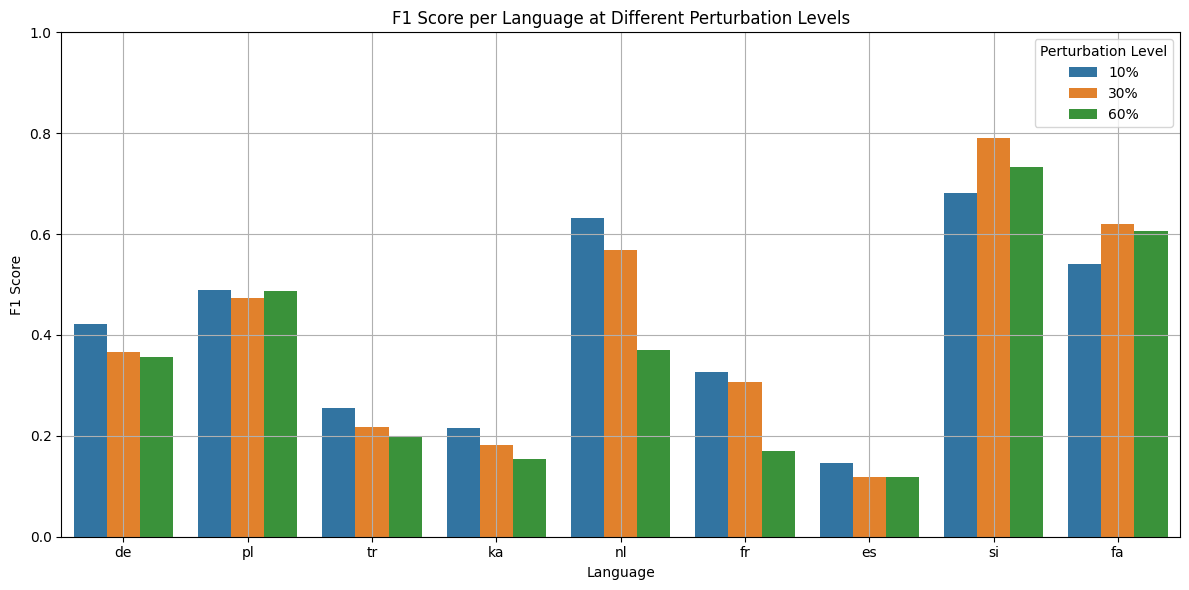

In [7]:
# رسم نمودار F1 بر اساس زبان و سطح نویز
plt.figure(figsize=(12, 6))
sns.barplot(data=lang_results_df, x="language", y="f1", hue="perturbation")
plt.title("F1 Score per Language at Different Perturbation Levels")
plt.ylabel("F1 Score")
plt.xlabel("Language")
plt.ylim(0, 1)
plt.legend(title="Perturbation Level")
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
# فقط برای یک سطح مثلاً 30%
error_file_path = perturbation_files["30%"]
df = pd.read_csv(error_file_path)
df["label"] = label_encoder.transform(df["label"])

encodings = tokenize_function(df["claim"].tolist())

dataset = Dataset.from_dict({
    "input_ids": encodings["input_ids"],
    "attention_mask": encodings["attention_mask"],
    "labels": df["label"].tolist()
})

outputs = trainer.predict(dataset)
predictions = np.argmax(outputs.predictions, axis=1)
true_labels = outputs.label_ids

# استخراج اشتباهات
wrong_indices = np.where(predictions != true_labels)[0]
error_rows = []
for i in wrong_indices:
    error_rows.append({
        "claim": df.iloc[i]["claim"],
        "true_label": label_encoder.inverse_transform([true_labels[i]])[0],
        "predicted_label": label_encoder.inverse_transform([predictions[i]])[0],
        "source_language": df.iloc[i]["source_language"]
    })

# ذخیره در CSV
error_df = pd.DataFrame(error_rows)
error_df.to_csv("/content/model_misclassifications_30percent.csv", index=False)
print(f"✅ Saved {len(error_df)} misclassified samples to /content/model_misclassifications_30percent.csv")


✅ Saved 942 misclassified samples to /content/model_misclassifications_30percent.csv
